#**FACE MASK DETECTOR**
![](https://i.imgur.com/anxeE2K.png)

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks or not wearing them.

- The dataset includes train, validation, and test data, already split into seperate folders.

- The classes are: Withmask and Withoutmask

Dataset can be accessed from Kaggle via this link: https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset?select=Face+Mask+Dataset


## Load dataset

In [1]:
!pip install kaggle

api_token = {"username":"thinhcao","key":"7fdb3f7719799a83bfad1f20ff235e14"}
import json
import zipfile
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json


In [2]:
!kaggle config path -p /content
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
 97% 321M/330M [00:12<00:00, 25.7MB/s]
100% 330M/330M [00:12<00:00, 26.7MB/s]


In [3]:
zip_ref = zipfile.ZipFile('./face-mask-12k-images-dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
# ! rm -rf '/content/face-mask-12k-images-dataset.zip'

In [5]:
# number of trainset
!ls 'Face Mask Dataset'/Train/*/* | wc -l

10000


In [6]:
# number of validation set
!ls 'Face Mask Dataset'/Validation/*/* | wc -l

800


In [7]:
# number of testset
!ls 'Face Mask Dataset'/Test/*/* | wc -l

992


## Data Explore

In [8]:
import os
import random
import pathlib 
import IPython.display as display
from matplotlib import pyplot as plt

In [9]:
train_dir = os.path.join('/content/Face Mask Dataset/Train')
train_dir = pathlib.Path(train_dir)
train_count = len(list(train_dir.glob('*/*')))
print(f'Number of train: {train_count}')

val_dir = os.path.join('/content/Face Mask Dataset/Validation')
val_dir = pathlib.Path(val_dir)
val_count = len(list(val_dir.glob('*/*')))
print(f'Number of validation: {val_count}')


Number of train: 10000
Number of validation: 800


In [13]:
# get all the img paths
all_train_paths = list(train_dir.glob('*/*'))
all_train_paths = [str(path) for path in all_train_paths]
random.shuffle(all_train_paths)
print(all_train_paths[0]) # to test


# get all the labels
all_train_labels = [pathlib.Path(path).parent.name for path in all_train_paths]
print(all_train_labels[100]) # to test

/content/Face Mask Dataset/Train/WithoutMask/2418.png
WithoutMask


In [14]:
# With_mask train dir
train_with_mask = pathlib.Path(os.path.join('/content/Face Mask Dataset/Train/WithMask'))
all_mask = [str(path) for path in list(train_with_mask.glob('*'))]

# Without_mask train dir
train_no_mask = pathlib.Path(os.path.join('/content/Face Mask Dataset/Train/WithoutMask'))
no_mask = [str(path) for path in list(train_no_mask.glob('*'))]

### Display images

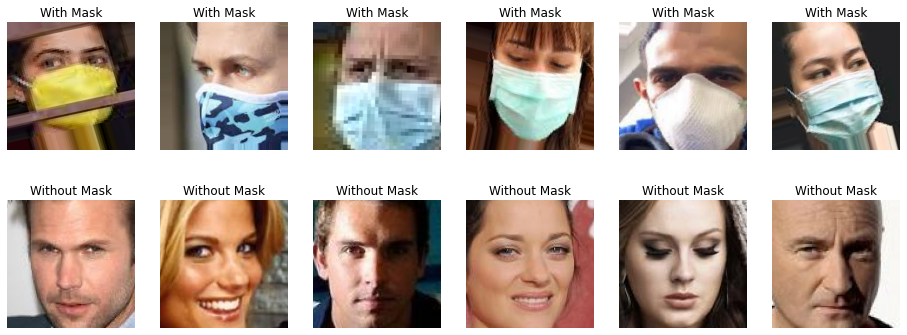

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

fig = plt.figure(figsize = (16,6))
for i in range(6):
    sample = random.choice(range(len(all_mask)))
    
    img = mpimg.imread(all_mask[sample])
    plt.subplot(2, 6, i + 1).axis('Off') 
    plt.title("With Mask")
    plt.imshow(img)

    img = mpimg.imread(no_mask[sample])
    plt.subplot(2, 6, i + 7).axis('Off') 
    plt.title("Without Mask")
    plt.imshow(img)
    
plt.show()

## Data Preprocessing anf Modelling

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.metrics import Recall
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
import math
import numpy as np
import pandas as pd

In [17]:
TRAIN_DATA_DIR = os.path.join('/content/Face Mask Dataset/Train')
VALIDATION_DATA_DIR = os.path.join('/content/Face Mask Dataset/Validation')

TRAIN_SAMPLES = len(list(pathlib.Path(TRAIN_DATA_DIR).glob('*/*')))
VALIDATION_SAMPLES = len(list(pathlib.Path(VALIDATION_DATA_DIR).glob('*/*')))

print(f'Train: {TRAIN_SAMPLES}')
print(f'Validation: {VALIDATION_SAMPLES}')

Train: 10000
Validation: 800


In [18]:
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

In [19]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2)

validation_datagen = ImageDataGenerator(rescale=1/255)

In [20]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR, 
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DATA_DIR, 
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = False,
    seed = 42,
    class_mode = 'binary')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [21]:
train_generator.class_indices, validation_generator.class_indices

({'WithMask': 0, 'WithoutMask': 1}, {'WithMask': 0, 'WithoutMask': 1})

## Build a DNN model

### Model Architecture

In [22]:
model = Sequential([
     Conv2D(64, (2,2), input_shape = (224,224,3), activation = 'relu'),
     MaxPooling2D(pool_size = (2,2)),
     Conv2D(128, (3,3), activation = 'relu'),
     MaxPooling2D(pool_size = (2,2)),
     Conv2D(256, (3,3), activation = 'relu'),
     MaxPooling2D(pool_size = (2,2)),
     Flatten(),
     Dense(256, activation = 'relu'),
     Dropout(0.2),
     Dense(64, activation = 'relu'),
     Dropout(0.1),
     Dense(1, activation = 'sigmoid')
])


### Callbacks:
- ModelCheckpoint
- EarlyStopping
- ReduceLRonPlateau

In [23]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = "Mask_Detect1.hdf5"

checker = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,save_best_only=True,verbose=1)

early = EarlyStopping(monitor='loss',patience = 6,mode = 'min')

reducer = ReduceLROnPlateau(monitor='loss', factor=0.75, patience = 2, verbose= 1,
                            cooldown=0, mode='auto',min_delta=0.0001, min_lr=0.00001)

# callback list: ModelCheckpoint, reduceLROnPlat, EarlyStopping
callbacks = [checker, reducer, early]

### Compile model

In [24]:
model.compile(loss= 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'],
)

history = model.fit(train_generator,
          epochs=10,
          validation_data = validation_generator,
          callbacks = callbacks)

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.2977 - acc: 0.8874
Epoch 00001: val_loss improved from inf to 0.13098, saving model to Mask_Detect1.hdf5
313/313 [==============================] - 106s 339ms/step - loss: 0.2977 - acc: 0.8874 - val_loss: 0.1310 - val_acc: 0.9438
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.1668 - acc: 0.9403
Epoch 00002: val_loss improved from 0.13098 to 0.09973, saving model to Mask_Detect1.hdf5
313/313 [==============================] - 106s 340ms/step - loss: 0.1668 - acc: 0.9403 - val_loss: 0.0997 - val_acc: 0.9638
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.1585 - acc: 0.9457
Epoch 00003: val_loss did not improve from 0.09973
313/313 [==============================] - 106s 338ms/step - loss: 0.1585 - acc: 0.9457 - val_loss: 0.1214 - val_acc: 0.9538
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.1524 - acc: 0.9480
Epoch 00004: val_loss did not impr

In [25]:
# Visualize model history
def plot_history(history, key='loss'):

    val = plt.plot(history.epoch, history.history['val_'+key],'--', label=key.title() +' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(), label=key.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

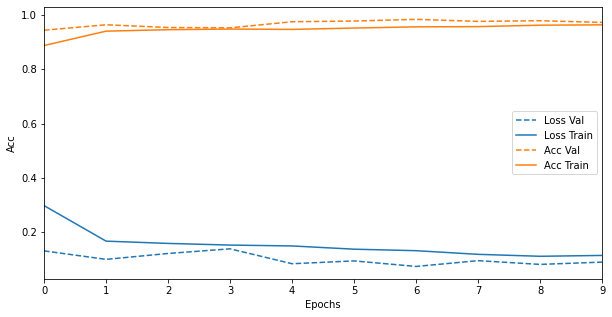

In [26]:
plt.figure(figsize=(10,5))
plot_history(history, key = 'loss')
plot_history(history, key = 'acc')

In [27]:
loss, acc = model.evaluate(validation_generator)
loss, acc

25/25 [==============================] - 1s 54ms/step - loss: 0.0896 - acc: 0.9725


(0.0896180048584938, 0.9725000262260437)

## Error Analysis

In [28]:
 prediction = (model.predict(validation_generator) > 0.5).astype("int32")
prediction = prediction.flatten()
prediction[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [29]:
classes = validation_generator.class_indices
classes_index = {v:k for k,v in classes.items()}
classes_index

{0: 'WithMask', 1: 'WithoutMask'}

In [31]:
validation_paths = [str(path) for path in list(pathlib.Path('/content/Face Mask Dataset/Validation').glob("*/*"))]
validation_labels = [classes[pathlib.Path(path).parent.name] for path in validation_paths]


In [32]:
compare = pd.DataFrame({"Actual": validation_labels,"Prediction": prediction})
wrong_predict = compare[compare.Actual != compare.Prediction].index
wrong_predict

Int64Index([ 26,  40,  64,  71,  87,  98, 120, 150, 225, 274, 288, 297, 355,
            363, 385, 392, 465, 510, 594, 735, 776, 790],
           dtype='int64')

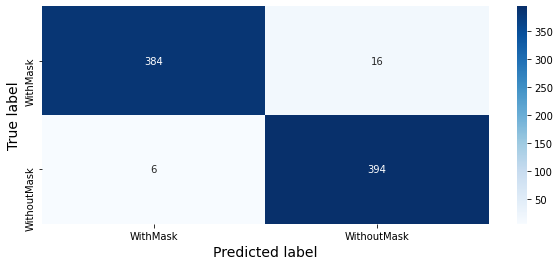

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(validation_labels, prediction)
plt.figure(figsize = (10,4))
sns.heatmap(cm, annot=True,fmt='g', cmap='Blues', 
            xticklabels=['WithMask','WithoutMask'], 
            yticklabels=['WithMask','WithoutMask']
            )
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label',fontsize = 14)
plt.show()

In [ ]:
classes = validation_generator.class_indices
classes

{'WithMask': 0, 'WithoutMask': 1}

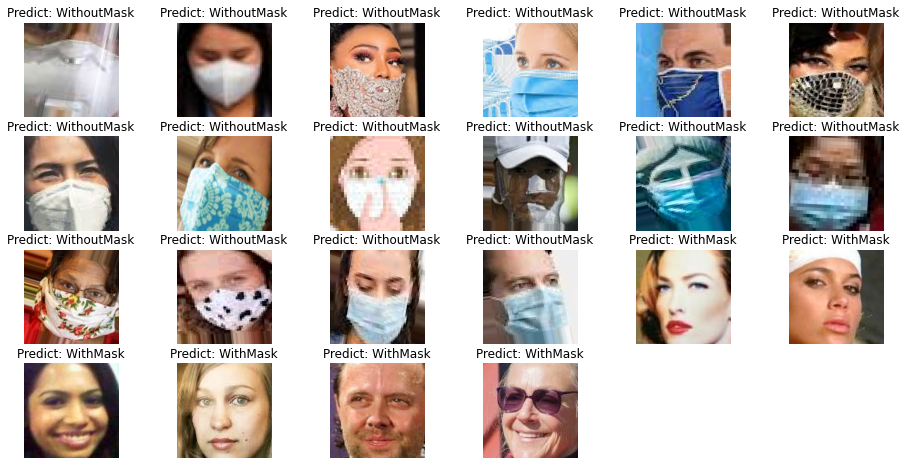

In [38]:
from tensorflow.keras.preprocessing import image

fig = plt.figure(figsize = (16,8))
i = 0
for index in list(wrong_predict):
  plt.subplot(4,6, i + 1)
  img_path = validation_paths[index] 
  img = image.load_img(img_path, target_size=(224,224))
  plt.imshow(img)
  plt.title(f'Predict: {classes_index[prediction[index]]}')
  plt.axis('Off')
  i += 1

## Apply transfer learning: MobileNetV2

### Create a model with MobileNetV2

In [39]:
def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH,IMG_HEIGHT,3))
    for layer in base_model.layers[:]:
        layer.trainable = False # Freeze the layers
    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.1)(custom_model)
    predictions = Dense(1, activation='sigmoid')(custom_model)
    
    return Model(inputs=input, outputs=predictions)

In [40]:
model_Mbv2 = model_maker()
model_Mbv2.compile(loss= 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'],
              )
model_Mbv2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 3,294,529
Trainable params: 65,665
Non-trainable params: 3,228,864
_______________________________________

In [41]:
checkpoint_path = "/content/drive/My Drive/Kaggle/Mask_detect_MbN2.h5"

checker = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,save_best_only=True,verbose=1)

early = EarlyStopping(monitor='loss',patience = 6,mode = 'min')

reducer = ReduceLROnPlateau(monitor='loss', factor=0.75, patience = 2, verbose= 1,
                            cooldown=0, mode='auto',min_delta=0.0001, min_lr=0.00001)

# callback list: ModelCheckpoint, reduceLROnPlat, EarlyStopping
callbacks = [checker, reducer, early]

In [42]:
history_2 = model_Mbv2.fit(train_generator,
          epochs=10,
          validation_data = validation_generator, 
          callbacks = callbacks)

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.0568 - acc: 0.9794
Epoch 00001: val_loss improved from inf to 0.02239, saving model to /content/drive/My Drive/Kaggle/Mask_detect_MbN2.h5
313/313 [==============================] - 106s 340ms/step - loss: 0.0568 - acc: 0.9794 - val_loss: 0.0224 - val_acc: 0.9925
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.0217 - acc: 0.9927
Epoch 00002: val_loss improved from 0.02239 to 0.01264, saving model to /content/drive/My Drive/Kaggle/Mask_detect_MbN2.h5
313/313 [==============================] - 108s 345ms/step - loss: 0.0217 - acc: 0.9927 - val_loss: 0.0126 - val_acc: 0.9950
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0172 - acc: 0.9942
Epoch 00003: val_loss improved from 0.01264 to 0.01112, saving model to /content/drive/My Drive/Kaggle/Mask_detect_MbN2.h5
313/313 [==============================] - 108s 346ms/step - loss: 0.0172 - acc: 0.9942 - val_loss: 0.0111 - val

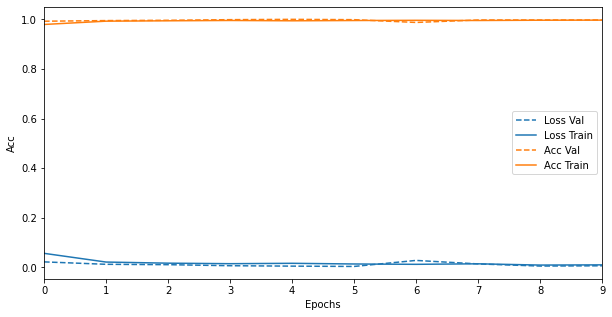

In [43]:
plt.figure(figsize=(10,5))
plot_history(history_2, key = 'loss')
plot_history(history_2, key = 'acc')

In [44]:
loss, acc = model_Mbv2.evaluate(validation_generator)
loss, acc

25/25 [==============================] - 1s 56ms/step - loss: 0.0067 - acc: 0.9975


(0.00665779784321785, 0.9975000023841858)

In [45]:
model_Mbv2.save('/content/drive/My Drive/Kaggle/Mbv2.h5')

## Test

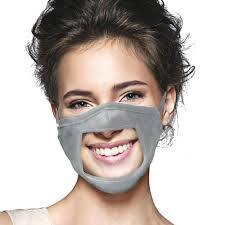


[[0.10571856]]
{'WithMask': 0, 'WithoutMask': 1}


In [57]:
from tensorflow.keras.preprocessing import image

img_path = '/content/drive/My Drive/Img test/Mask1.jpg'
display.display(display.Image(img_path))
print()
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model_Mbv2.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[2.6502105e-09]]
{'WithMask': 0, 'WithoutMask': 1}


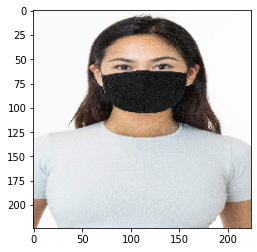

In [58]:

img_path = '/content/drive/My Drive/Img test/Mask3.jpg'
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model_Mbv2.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[0.8278651]]
{'WithMask': 0, 'WithoutMask': 1}


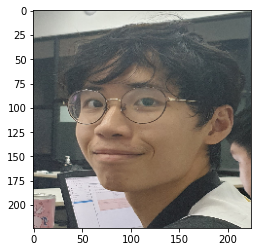

In [60]:

img_path = '/content/drive/My Drive/Img test/20200919_151721.jpg'
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model_Mbv2.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[0.15500517]]
{'WithMask': 0, 'WithoutMask': 1}


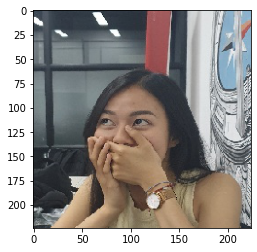

In [61]:

img_path = '/content/drive/My Drive/Img test/20200920_192114.jpg'
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model_Mbv2.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[5.42154e-08]]
{'WithMask': 0, 'WithoutMask': 1}


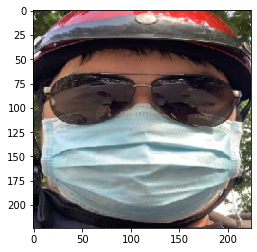

In [62]:
img_path = '/content/drive/My Drive/Img test/20200920_192531.jpg'
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model_Mbv2.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[0.00073004]]
{'WithMask': 0, 'WithoutMask': 1}


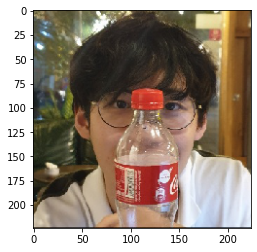

In [63]:
img_path = '/content/drive/My Drive/Img test/20200920_192241.jpg'
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model_Mbv2.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

[[3.9118468e-06]]
{'WithMask': 0, 'WithoutMask': 1}


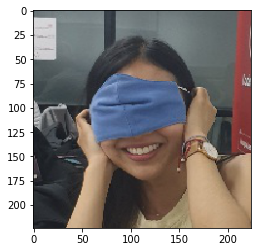

In [64]:
img_path = '/content/drive/My Drive/Img test/20200920_192156.jpg'
img = image.load_img(img_path, target_size=(224,224))
plt.imshow(img)
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array) # Preprocess the image
prediction = model_Mbv2.predict(preprocessed_img)
print(prediction)
print(validation_generator.class_indices)

## Conclusion
1. The model works well in the ideal condtions: clear images, no obstacle.
2.  However, the model fails to detect when someone is covering his/her face with other objects (bottles of water, hands,...) not face masks.
2. To improve the model, we should collect more data of various scenarios, not just in the ideal conditions.